# Trabalho A1 - Tiago Barradas - 243902

## Part 1 - Data loading and pre-processing

Primeiramente, vamos baixar o dataset e começar a explorá-lo em busca de problemas.

In [ ]:
import os
import urllib
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=11)
mpl.rc('xtick', labelsize=13)
mpl.rc('ytick', labelsize=13)
mpl.rc('grid', alpha=0)
import seaborn as sns



# Baixa o dataset
URL = "https://raw.githubusercontent.com/tidyverse/ggplot2/main/data-raw/diamonds.csv"
DATASET_PATH = os.path.join("dataset", "diamonds.csv")
os.makedirs("dataset", exist_ok=True)
urllib.request.urlretrieve(URL, DATASET_PATH)

diamonds = pd.read_csv(DATASET_PATH)

In [ ]:
diamonds.info()

A princípo, não há nenhum datapoint com features faltantes, o que é um ótimo começo. Vamos agora checar se há datapoints repetidos:

In [ ]:
diamonds.duplicated().value_counts()

In [ ]:
diamonds = diamonds[~diamonds.duplicated()]
diamonds.info()

Após remover os datapoints repetidos usando o método .duplicated(), temos um dataset com 53794 entradas. Para evitar quaisquer problemas com índices faltantes, irei resetar os índices para que eles possuam um range adequado. Depois disso, vamos checar as features "cut", "color", e "clarity" para nos certificar que todos possuem valores adequados, conforme a [referência indicada](https://ggplot2.tidyverse.org/reference/diamonds.html).

In [ ]:
diamonds.reset_index(inplace=True, drop=True)
diamonds.info()

In [ ]:
diamonds["cut"].value_counts()


In [ ]:
diamonds["color"].value_counts()


In [ ]:
diamonds["clarity"].value_counts()

Agora que nos certificamos que o dataset está limpo, vamos trabalhar nos histogramas:

In [ ]:
classes = diamonds["cut"].value_counts().index 


for key in diamonds.keys():
    fig, axs = plt.subplots(2, figsize=(11, 10))
    fig.suptitle(f"Histograma de {key}", fontsize=24)
    sns.histplot(ax=axs[0], data=diamonds, x=diamonds[key], 
                 stat='density', bins=50, common_norm=True)

    sns.histplot(ax=axs[1], data=diamonds, x=diamonds[key], 
                 stat='density', bins=50, common_norm=True, hue="cut")
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig.show()

Com os histogramas feitos, vamos agora fazer nossa matriz de figuras, contendo histogramas e scatterplots que mostram a correlação entre as diversas features:

In [ ]:
def correlation(x, y, **kws):
    corr = np.corrcoef(diamonds[x.name], diamonds[y.name])
    ax = plt.gca()  # Get current axis from the whole figure
    ax.annotate(f"Correlação: {round(corr[0, 1], 2)}", 
                xy=(0.25, 0.45), xycoords=ax.transAxes)
    plt.axis('off')


plot_matrix = sns.PairGrid(diamonds, hue='cut', diag_sharey=False)
plot_matrix.map_diag(sns.histplot, stat='density', bins=50, common_norm=True)
plot_matrix.map_lower(sns.scatterplot)
plot_matrix.map_upper(correlation)

Com isso, a primeira parte está concluída!

## Part 2 - K-nearest-neighbour classifier

Vamos dividir nosso dataset em training, validation e testing sets, e normalizar os valores presentes em cada feature do dataset para que elas passem a compartilhar uma mesma escala. Para isso, é necessário primeiro remover as variáveis categóricas do dataset.

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


X_diamonds = diamonds.drop(["cut", "color", "clarity"], axis=1)
y_diamonds = diamonds["cut"]

X_train, X_test, y_train, y_test = train_test_split(X_diamonds, y_diamonds, test_size=0.2, random_state=42, stratify=y_diamonds)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.2, random_state=42, stratify=y_test) 

min_max_scaler = MinMaxScaler()
X_train[X_train.columns] = min_max_scaler.fit_transform(X_train)  # Usando essa sintaxe para ter retorno como DataFrame
X_test[X_test.columns] = min_max_scaler.transform(X_test)
X_val[X_val.columns] = min_max_scaler.transform(X_val)

X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
X_val.reset_index(drop=True, inplace=True)

y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)
y_val.reset_index(drop=True, inplace=True)

def trans_back(X, y, index):  # Function to transform back a feature to its original range
    diamonds_aux = np.c_[np.array(X)[:, :index], y, np.array(X)[:, -index:]]
    diamonds_transformed = min_max_scaler.inverse_transform(diamonds_aux)
    return diamonds_transformed[:, index]

Agora, vamos implementar nosso próprio estimator para realizar a classificação K-Nearest-Neighbours:

In [24]:
from sklearn.base import BaseEstimator
from collections import Counter

class KNearestNeighbours(BaseEstimator):
    def __init__(self, k=5, distances='euclidean'):
        self.k = k  # Number of nearest neighbours to consider
        self.distances = distances  # Can also be a matrix with precalculated distances
    
    def fit(self, X, y):
        self.X_train = X  # Training data (in a dataframe)
        self.y_train = y  # Training labels (in a series that gets converted)
        return self

    def predict(self, X):
        # X as array
        labels = []

        if self.distances=='euclidean':
            # For each new datapoint, calculate and sort by the distance to each training point,
            # and select the most common label in the k nearest neighbours
            for datapoint in X:  
                point_dist = np.linalg.norm(self.X_train - datapoint, axis=1)
                sorted_dist = np.argsort(point_dist)[:self.k]
                predicted_label = Counter(self.y_train[sorted_dist]).most_common(1)[0][0] 
                labels.append(predicted_label)
        else:
            # For each new datapoint, sort the previously calculated distances and 
            # select the most common label in the k nearest neighbours
            if self.distances.shape[1] != self.X_train.shape[0]:
                raise ValueError('Distances matrix must have the same number of columns as the number of datapoints in the training data')
            for datapoint in self.distances:
                sorted_dist = np.argsort(datapoint)[:self.k]
                predicted_label = Counter(self.y_train[sorted_dist]).most_common(1)[0][0] 
                labels.append(predicted_label)
        return np.array(labels)


Vamos pré-calcular as distâncias para salvar tempo computacional.

In [16]:
distances = []

for datapoint in np.array(X_test):  
    distances.append(np.linalg.norm(X_train - datapoint, axis=1))

distances = np.array(distances, dtype=np.float16)

In [25]:
from sklearn.metrics import accuracy_score

knn_dim = KNearestNeighbours(k=3, distances=distances)
knn_dim.fit(X_train, y_train)
y_pred = knn_dim.predict(np.array(X_test))


accuracy_score(y_test, y_pred)

/tmp/ipykernel_14493/2407361116.py:18: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self.distances=='euclidean':


0.6679446961775299

Por curiosidade, quero compará-la com o modelo nativo do Scikit-Learn:

In [26]:
from sklearn.neighbors import KNeighborsClassifier
skknn = KNeighborsClassifier(n_neighbors=3)
skknn.fit(X_train, y_train)
sky_pred = skknn.predict(X_test)

accuracy_score(y_test, sky_pred)

0.6674799581735796

Obtivemos praticamente o mesmo resultado! Isso indica que a matemática por trás do nosso próprio modelo está correta. A maior diferença entre essas duas implementações é a gigantesca eficiência de código presente na do SciKit-Learn (demorando menos de 1 segundo enquanto a minha implementação demora quase 1 minuto!). Levando isso em conta, eu usarei essa implementação mais rápida para os próximos passos do trabalho, a fim de economizar horas de código rodando.

Para montar as 35 combinações de diferentes features, usarei a função combinations do itertools:

In [28]:
from itertools import combinations

feature_combs = np.array(list(combinations(X_diamonds.keys(), 3)))
feature_combs[:10]

array([['carat', 'depth', 'table'],
       ['carat', 'depth', 'price'],
       ['carat', 'depth', 'x'],
       ['carat', 'depth', 'y'],
       ['carat', 'depth', 'z'],
       ['carat', 'table', 'price'],
       ['carat', 'table', 'x'],
       ['carat', 'table', 'y'],
       ['carat', 'table', 'z'],
       ['carat', 'price', 'x']], dtype='<U5')

Agora, implementarei uma classe Transformer do scikitlearn, que recebe como hiperparâmetro uma array de índices de DataFrame, que será usado para filtrar o DataFrame recebido conforme as features selecionadas. Usarei ele nos loops para testar todas as combinações de k e features, e salvarei esses dados em um dataframe pandas.

In [40]:
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Transformer that returns the filtered dataset based on the features given
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, features=None):
        self.features = features
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.features]

# Pipeline to be filter the features, which get fitted to the model
pipeline = Pipeline(
    [
        ('selector', FeatureSelector()),
        ('knn', KNeighborsClassifier()),
    ]
)

# Dict to be converted to pandas DataFrame
accuracies = {
    'knn__n_neighbors': [],
    'selector__features': [],
    'Accuracy': []
}


for k in [2, 5, 10, 15]:
    for features in feature_combs:
        pipeline.set_params(knn__n_neighbors=k, selector__features=features)
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        accuracies['knn__n_neighbors'].append(k)
        accuracies['selector__features'].append(features)
        accuracies['Accuracy'].append(accuracy_score(y_test, y_pred))

accuracies = pd.DataFrame(accuracies)
accuracies = accuracies.astype({'selector__features': 'str'})

Como podemos ver, os modelos mais precisos para prever a feature "cut" são os com os maiores números de neighbors e que se baseiam, principalmente, nas features "depth" e "table". Agora, vamos implementar o código da função de plotagem desses dados.

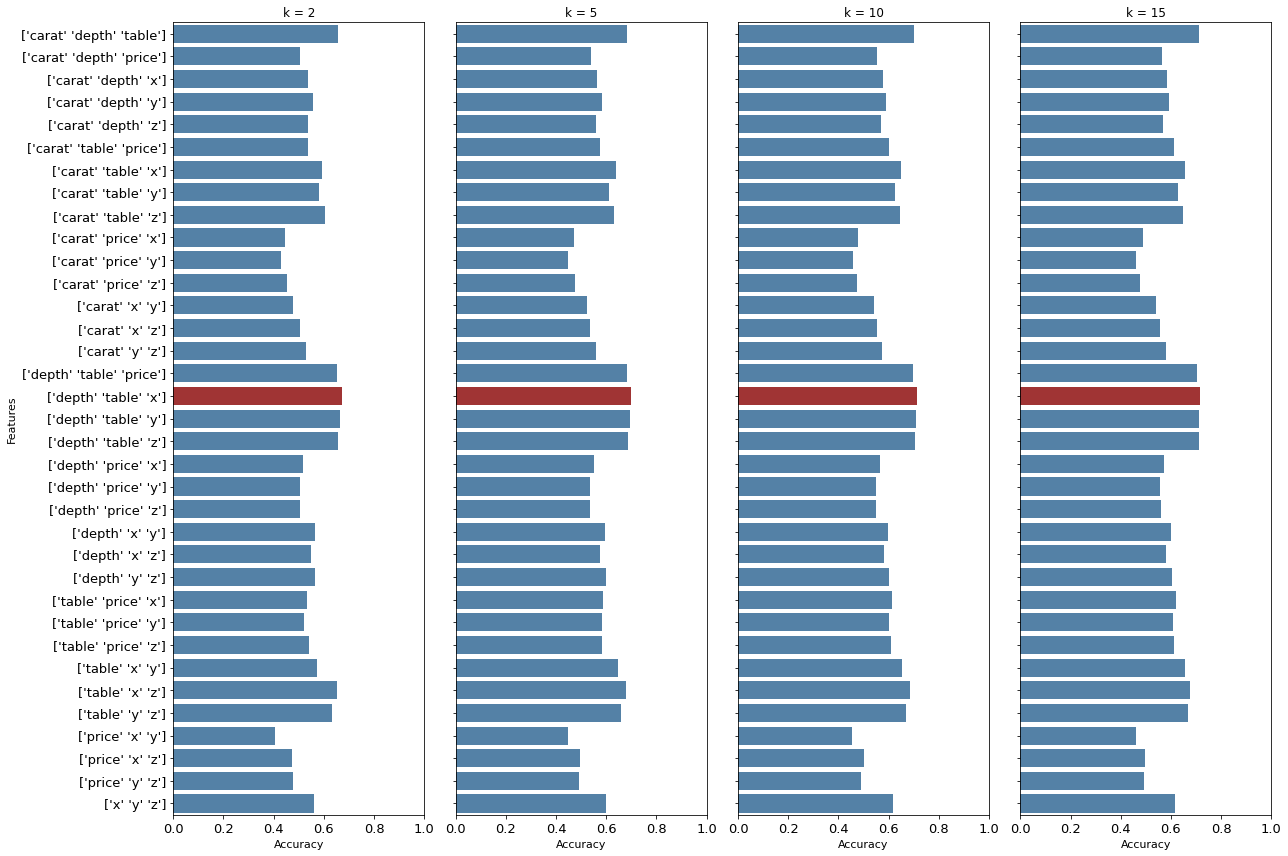

In [41]:
def plotFeatureByCategories(dataframe, feature, category):   
    list_of_ks = dataframe[category].unique()  # Gets the unique categories
    fig, axs = plt.subplots(nrows=1, ncols=list_of_ks.size, figsize=(18, 12))  # Determines the amount of subplots based on the categories

    is_first = True  
    for item, ax in zip(list_of_ks, axs.ravel()):  # Iterates through the axs and categories
        dataframe_aux = dataframe[dataframe[category] == item]  # Filters the dataframe based on the category

        colors = ['steelblue' if (x < max(dataframe_aux[feature])) else 'firebrick' for x in dataframe_aux[feature]]  # Colors the highest value in red

        sns.barplot(ax=ax, data=dataframe_aux, x=feature, y='selector__features', palette=colors)
        ax.set_title(f'k = {item}')
        ax.set(xlim=(0, 1))
        ax.set_ylabel('Features')

        if not is_first:  # Removes the labels if it's not the first plot
            ax.set_ylabel('')
            ax.set_yticklabels('', visible=False)
        is_first = False
        
    fig.tight_layout()
    fig.show()

plotFeatureByCategories(accuracies, 'Accuracy', 'knn__n_neighbors')

O gráfico mostra claramente que a combinação "depth, table, x" é a mais vantajosa independentemente dos valores de k checados. Com isso, a parte 2 do trabalho está concluída!

## Part 3 - Linear Regression

Primeiro, vamos redefinir os training, testing e validation sets para se adequar ao fato de que agora iremos tentar prever os valores de preço:

In [42]:
y_train_lr = X_train['price']
X_train_lr = X_train.drop(['price'], axis=1)

y_test_lr = X_test['price']
X_test_lr = X_test.drop(['price'], axis=1)

y_val_lr = X_val['price']
X_val_lr = X_val.drop(['price'], axis=1)

Agora, vamos implementar nosso estimator. Além dos que foram pedidos no trabalho, adicionei outros hiperparâmetros que podem ser interessantes para o algoritmo.

In [44]:
from sklearn.metrics import mean_squared_error


class LinearRegressionSolver(BaseEstimator):
    def __init__(self, solver='cf', max_iter=100, learning_rate=0.0001, 
                 weight_decay=0.1, tolerance=1e-6, batch_size=10):
        self.solver = solver 
        self.weight_decay = weight_decay
        self.max_iter = max_iter
        self.learning_rate = learning_rate
        self.tolerance = tolerance
        self.batch_size = batch_size
    
    def fit(self, X, y):
        self.X_train = np.array(np.c_[np.ones((X.shape[0], 1)), X.reset_index(drop=True)])  # Adding the bias term
        self.y_train = np.array(y.reset_index(drop=True))

        if self.solver == 'cf':  # Closed form solution
            A = np.eye(X.shape[1]+1)
            A[0, 0] = 0
            L2_factor = A*self.weight_decay
            inverse = np.linalg.inv(self.X_train.T @ self.X_train + L2_factor)
            self.weights = inverse @ self.X_train.T @ self.y_train

        elif self.solver == 'gd':  # Stochastic gradient descent
            self.weights = np.zeros((X.shape[1]+1))
            for i in range(self.max_iter):
                for start in range(0, self.X_train.shape[0], self.batch_size):
                    randi = np.random.randint(self.X_train.shape[0], size=(self.batch_size))
                    X_batch = self.X_train[randi]
                    y_batch = self.y_train[randi]
                    gradient = X_batch.T @ (X_batch @ self.weights - y_batch)
                    self.weights = self.weights - self.learning_rate * gradient
                    if np.sum(np.abs(gradient)) < self.tolerance:
                        print("Converges!")
                        break
        return self

    def predict(self, X):
        return np.c_[np.ones((X.shape[0], 1)), X] @ self.weights

Vamos testar e comparar os dois modelos!

In [53]:
lr = LinearRegressionSolver(solver='cf', weight_decay=0.1)
lr.fit(X_train_lr[:10000], y_train_lr[:10000])
y_pred_lr = lr.predict(X_test_lr)

y_test_back = trans_back(X_test_lr, y_test_lr, 3)
y_pred_back = trans_back(X_test_lr, y_pred_lr, 3)

print("Normalized RMSE: ", np.sqrt(mean_squared_error(y_test_lr, y_pred_lr)))
print("Real RMSE: ", np.sqrt(mean_squared_error(y_test_back, y_pred_back)))
print("True Values x Predicted Values:")
print(np.c_[y_test_back, np.round(y_pred_back, 0)][:10])

Normalized RMSE:  0.08180214495237242
Real RMSE:  1513.0942751840325
True Values x Predicted Values:
[[ 6391.  6680.]
 [ 1316.  1152.]
 [  769.    54.]
 [ 1841.  2348.]
 [  540.   -36.]
 [14247.  9554.]
 [ 1040.  1353.]
 [ 9355. 10445.]
 [ 6202.  6629.]
 [ 2196.  2934.]]


In [54]:
lr = LinearRegressionSolver(solver='gd', learning_rate=0.01, max_iter=1000, batch_size=10)
lr.fit(X_train_lr[:10000], y_train_lr[:10000])
y_pred_lr = lr.predict(X_test_lr)

y_test_back = trans_back(X_test_lr, y_test_lr, 3)
y_pred_back = trans_back(X_test_lr, y_pred_lr, 3)

print("Normalized RMSE: ", np.sqrt(mean_squared_error(y_test_lr, y_pred_lr)))
print("Real RMSE: ", np.sqrt(mean_squared_error(y_test_back, y_pred_back)))
print("True Values x Predicted Values:")
print(np.c_[y_test_back, np.round(y_pred_back, 0)][:10])

Normalized RMSE:  0.08348195560916724
Real RMSE:  1544.1657329027664
True Values x Predicted Values:
[[ 6391.  6333.]
 [ 1316.   875.]
 [  769.  -175.]
 [ 1841.  2048.]
 [  540.  -281.]
 [14247.  9193.]
 [ 1040.  1156.]
 [ 9355. 10080.]
 [ 6202.  6263.]
 [ 2196.  2615.]]


Podemos ver que as previsões não são muito precisas. É possível encontrar até mesmo preços negativos! Outra observação é que a Stochastic Gradient Descent parece ter uma performance ligeiramente pior que o modelo Closed Form. Agora, vamos plotar os valores reais e os previstos:

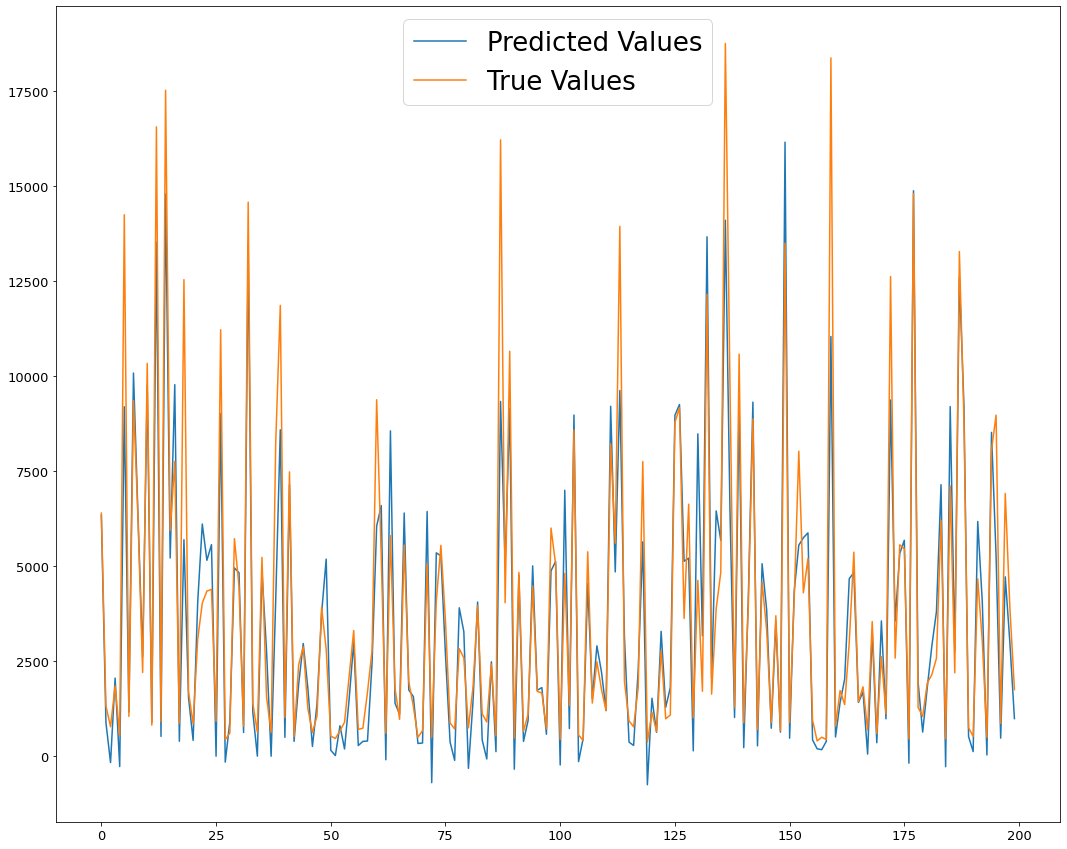

In [55]:
fig, ax = plt.subplots(figsize=(18, 15))

ax.plot(np.arange(0,trans_back(X_test_lr, y_pred_lr, 3)[:200].size), 
        trans_back(X_test_lr, y_pred_lr, 3)[:200],
        label="Predicted Values")
ax.plot(np.arange(0,trans_back(X_test_lr, y_test_lr, 3)[:200].size), 
        trans_back(X_test_lr, y_test_lr, 3)[:200],
        label="True Values")

leg = ax.legend(prop={"size": 26})

In [ ]:
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=0)
ridge_reg.fit(X_train_lr, y_train_lr)
y_pred_ridge = ridge_reg.predict(X_test_lr)

np.sqrt(mean_squared_error(y_test_lr, y_pred_ridge))

## Part 4 - Model Comparison

In [ ]:
# Set of hyperparameter combinations to try out
param_grid = {'knn__n_neighbors': [2, 5, 10, 15], 
              'selector__features': feature_combs.tolist()}

grid_search = GridSearchCV(pipeline, 
                           param_grid=param_grid, 
                           cv=4, 
                           scoring='accuracy')

grid_search.fit(X_train, y_train)

accuracy_score(grid_search.predict(X_val), y_val)


accuracies = pd.concat(
    [
        pd.DataFrame(grid_search.cv_results_["params"]),
        pd.DataFrame(grid_search.cv_results_["mean_test_score"], columns=["Accuracy"])
    ], 
    axis=1
)

accuracies = accuracies.astype({"selector__features": str})
accuracies.sort_values(by="Accuracy", ascending=False).head(10)